In [2]:
import gymnasium as gym
import numpy as np
import optuna
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

In [3]:

class IbuprofenEnv(gym.Env):
    """
    An OpenAI Gym environment simulating the pharmacokinetics of ibuprofen in a human body.

    This environment models the concentration of ibuprofen in the bloodstream after repeated
    doses over a period of time. The agent's goal is to maintain the drug concentration within
    a therapeutic range while avoiding toxicity.

    Attributes:
        action_space (gym.spaces.Discrete): The discrete action space representing dose levels (0 to 4).
        observation_space (gym.spaces.Box): The observation space representing the plasma concentration (0 to 100).
        therapeutic_range (tuple): A tuple defining the lower and upper bounds of the therapeutic range (10 to 50).
        half_life (float): The drug's half-life in hours.
        clearance_rate (float): The clearance rate calculated from the half-life.
        time_step_hours (int): The time step in hours between actions.
        bioavailability (float): Fraction of the drug that reaches systemic circulation (default 0.9).
        volume_of_distribution (float): Volume of distribution in L/kg (default 0.15).
        max_steps (int): Maximum number of steps (24 hours).
        current_step (int): Counter for the current time step in the episode.
        plasma_concentration (float): Current plasma concentration of the drug in µg/mL.
        normalize (bool): Whether to normalize state observations.
        state_buffer (list): A buffer storing past plasma concentrations for normalization.

    Methods:
        reset(seed=None, **kwargs):
            Resets the environment to the initial state.

        step(action):
            Takes a step in the environment with a given action and updates the state.

        _normalize(state):
            Normalizes the state based on past concentrations if normalization is enabled.
    """

    def __init__(self, normalize=False):
        """
        Initializes the Ibuprofen environment.

        Args:
            normalize (bool): Whether to normalize state observations.
        """
        super(IbuprofenEnv, self).__init__()

        # Define the action space: actions represent discrete doses (0-4 units, each unit = 200 mg)
        self.action_space = gym.spaces.Discrete(5)

        # Observation space: plasma concentration of ibuprofen (0-100 µg/mL)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)

        # Pharmacokinetics parameters
        self.therapeutic_range = (10, 50)  # Target therapeutic range for the drug
        self.half_life = 2.0  # Half-life of the drug in hours
        self.clearance_rate = 0.693 / self.half_life  # Clearance rate calculated using half-life
        self.time_step_hours = 1  # Time step in hours
        self.bioavailability = 0.9  # Proportion of the drug absorbed into systemic circulation
        self.volume_of_distribution = 0.15  # Volume of distribution in L/kg
        self.max_steps = 24  # Maximum simulation steps (24 hours)

        # Initial states
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.normalize = normalize
        self.state_buffer = []  # Stores historical plasma concentrations for normalization

    def reset(self, seed=None, **kwargs):
        """
        Resets the environment to the initial state.

        Args:
            seed (int, optional): Random seed for reproducibility.

        Returns:
            tuple: The initial state and an empty info dictionary.
        """
        super().reset(seed=seed)
        self.current_step = 0  # Reset step counter
        self.plasma_concentration = 0.0  # Reset plasma concentration
        self.state_buffer = []  # Clear state buffer
        state = np.array([self.plasma_concentration], dtype=np.float32)  # Initial state
        return self._normalize(state), {}

    def step(self, action):
        """
        Takes a step in the environment based on the selected action.

        Args:
            action (int): The chosen action, representing the dose (0-4 units).

        Returns:
            tuple: Contains the next state, reward, done flag, truncated flag, and info dictionary.
        """
        # Calculate the administered dose (200 mg per unit of action)
        dose_mg = action * 200
        # Calculate the absorbed dose after bioavailability
        absorbed_mg = dose_mg * self.bioavailability
        # Calculate the resulting plasma concentration (µg/mL)
        absorbed_concentration = absorbed_mg / (self.volume_of_distribution * 70)  # Assume 70 kg body weight
        # Update plasma concentration with the absorbed dose
        self.plasma_concentration += absorbed_concentration
        # Apply clearance (exponential decay)
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        # Generate the new state
        state = np.array([self.plasma_concentration], dtype=np.float32)
        normalized_state = self._normalize(state)  # Normalize the state if enabled

        # Append current concentration to state buffer
        self.state_buffer.append(self.plasma_concentration)

        # Calculate reward based on the therapeutic range
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10  # Positive reward for being in the therapeutic range
        else:
            # Penalize for concentrations outside the therapeutic range
            if self.plasma_concentration < self.therapeutic_range[0]:
                reward = -5 - (self.therapeutic_range[0] - self.plasma_concentration) * 0.5
            elif self.plasma_concentration > self.therapeutic_range[1]:
                reward = -5 - (self.plasma_concentration - self.therapeutic_range[1]) * 0.5

        # Apply a severe penalty for toxic concentrations (above 100 µg/mL)
        if self.plasma_concentration > 100:
            reward -= 15

        # Update step counter and check termination conditions
        self.current_step += 1
        done = self.current_step >= self.max_steps  # Episode ends after max steps
        truncated = False  # No explicit truncation condition in this environment
        info = {}  # Additional diagnostics can be added to this dictionary

        return normalized_state, reward, done, truncated, info
    
    def _normalize(self, state):
        """
        Normalizes the state based on the mean and standard deviation of past concentrations.

        Args:
            state (numpy.ndarray): The current state (plasma concentration).

        Returns:
            numpy.ndarray: The normalized state if normalization is enabled; otherwise, the original state.
        """
        if self.normalize and len(self.state_buffer) > 1:
            mean = np.mean(self.state_buffer)
            std = np.std(self.state_buffer) + 1e-8  # Add a small value to prevent division by zero
            return (state - mean) / std
        return state

In [4]:
class RewardLoggingCallback(BaseCallback):
    def __init__(self):
        super(RewardLoggingCallback, self).__init__()
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        # Accumulate reward for the current step
        self.current_episode_reward += self.locals["rewards"][0]

        # If the episode ends, log the reward
        if self.locals["dones"][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        return True

In [5]:
def optimize_ppo(trial):
    env = DummyVecEnv([lambda: IbuprofenEnv(normalize=True)])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    n_epochs = trial.suggest_int("n_epochs", 3, 10)
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    n_steps = trial.suggest_int("n_steps", 64, 2048, step=64)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.99)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        batch_size=batch_size,
        n_steps=n_steps,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        verbose=0,
    )
    model.learn(total_timesteps=10000)

    rewards = []
    for _ in range(100):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)

    return np.mean(rewards)

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=100)

best_params = study.best_params
print("Best Parameters:", best_params)

[I 2024-12-04 12:41:18,460] A new study created in memory with name: no-name-d3d23f1d-e6d1-40dd-b133-6b51ecee85e6
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 352, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1984`, after every 5 untruncated mini-batches, there will be a truncated mini-batch of size 224
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1984 and n_envs=1)
  warnings.warn(
[I 2024-12-04 12:41:38,075] Trial 0 finished with value: -240.0 and parameters: {'learning_rate': 0.0002706261353569497, 'gamma': 0.9359851929950406, 'n_epochs': 5, 'ent_coef': 0.0006582273782348922, 'batch_size': 352, 'n_steps': 1984, 'gae_lambda': 0.9389854330945168, 'clip_range': 0.11786186954425237}. Best is trial 0 with value: -240.0.
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have sp

Best Parameters: {'learning_rate': 0.0008350317196890158, 'gamma': 0.9577742719864756, 'n_epochs': 10, 'ent_coef': 0.0041451012305191385, 'batch_size': 32, 'n_steps': 1024, 'gae_lambda': 0.9117270187885773, 'clip_range': 0.22963596297397976}


In [7]:
env = DummyVecEnv([lambda: IbuprofenEnv(normalize=True)])

final_model = PPO(
    "MlpPolicy",
    env,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    n_epochs=best_params["n_epochs"],
    ent_coef=best_params["ent_coef"],
    batch_size=best_params["batch_size"],
    n_steps=best_params["n_steps"],
    gae_lambda=best_params["gae_lambda"],
    clip_range=best_params["clip_range"],
    verbose=1,
)
callback = RewardLoggingCallback()
final_model.learn(total_timesteps=24000, callback=callback)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1620 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 950         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.020386226 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.23        |
|    entropy_loss         | -1.59       |
|    explained_variance   | -0.00181    |
|    learning_rate        | 0.000835    |
|    loss                 | 1.02e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0421     |
|    value_loss           | 2.04e+04    |
-----------------------------------------
-----------------

In [8]:
# Training Loop with Dynamic Time Horizon
# Initialize variables for dynamic time horizon
initial_horizon = 6  # Start with a small time horizon (e.g., 6 hours)
max_horizon = 24     # Full time period (24 hours, in your case)
horizon_increment = 2  # Increase the horizon incrementally
time_horizon = initial_horizon

reward_history = []

# Use a loop for multiple training episodes
for episode in range(1000):  # Number of training episodes
    # Dynamically update the time horizon
    time_horizon = min(max_horizon, initial_horizon + episode * horizon_increment)

    # Reset environment at the beginning of each episode
    state = env.reset()

    total_reward = 0
    plasma_concentration_history = []

    for t in range(time_horizon):  # Use the dynamic time horizon
        # Use the SB3 predict method for actions
        action, _ = final_model.predict(state, deterministic=False)

        # Take a step in the environment
        new_state, reward, done, infos = env.step(action)
        plasma_concentration_history.append(new_state[0])

        # Accumulate the reward
        total_reward += reward

        # Update the current state
        state = new_state

        if done:
            break

    # Append total reward for the episode
    reward_history.append(total_reward)

    # Log progress every 10 episodes
    if episode % 10 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}, Time Horizon = {time_horizon}")


Episode 0: Total Reward = [60.], Time Horizon = 6
Episode 10: Total Reward = [240.], Time Horizon = 24
Episode 20: Total Reward = [240.], Time Horizon = 24
Episode 30: Total Reward = [240.], Time Horizon = 24
Episode 40: Total Reward = [240.], Time Horizon = 24
Episode 50: Total Reward = [224.28635], Time Horizon = 24
Episode 60: Total Reward = [240.], Time Horizon = 24
Episode 70: Total Reward = [240.], Time Horizon = 24
Episode 80: Total Reward = [240.], Time Horizon = 24
Episode 90: Total Reward = [240.], Time Horizon = 24
Episode 100: Total Reward = [240.], Time Horizon = 24
Episode 110: Total Reward = [240.], Time Horizon = 24
Episode 120: Total Reward = [240.], Time Horizon = 24
Episode 130: Total Reward = [240.], Time Horizon = 24
Episode 140: Total Reward = [240.], Time Horizon = 24
Episode 150: Total Reward = [220.], Time Horizon = 24
Episode 160: Total Reward = [182.13293], Time Horizon = 24
Episode 170: Total Reward = [220.], Time Horizon = 24
Episode 180: Total Reward = [24

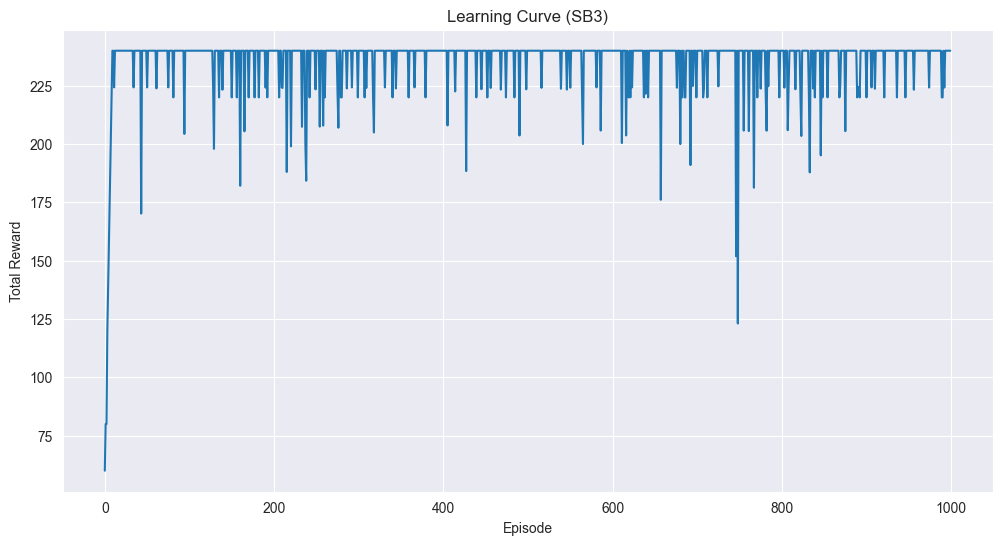

In [25]:
# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve (SB3)")
plt.grid(True)
plt.show()

In [10]:

# Evaluation Loop
evaluation_episodes = 100  # Number of episodes for evaluation

evaluation_rewards = []
plasma_concentration_trajectories = []

# Access the underlying environment from DummyVecEnv
underlying_env = env.envs[0]  # envs[0] gives access to the unwrapped IbuprofenEnv

for episode in range(evaluation_episodes):
    state, _ = underlying_env.reset()

    total_reward = 0
    plasma_concentration_history = [state[0]]  # Track plasma concentration

    for _ in range(underlying_env.max_steps):  # Use max_steps from the underlying environment
        # Use the SB3 predict method for actions
        action, _ = final_model.predict(state, deterministic=True)

        # Take the chosen action in the environment
        new_state, reward, done, truncated, _ = underlying_env.step(action)
        plasma_concentration_history.append(new_state[0])

        state = new_state
        total_reward += reward

        if done or truncated:
            break

    evaluation_rewards.append(total_reward)
    plasma_concentration_trajectories.append(plasma_concentration_history)


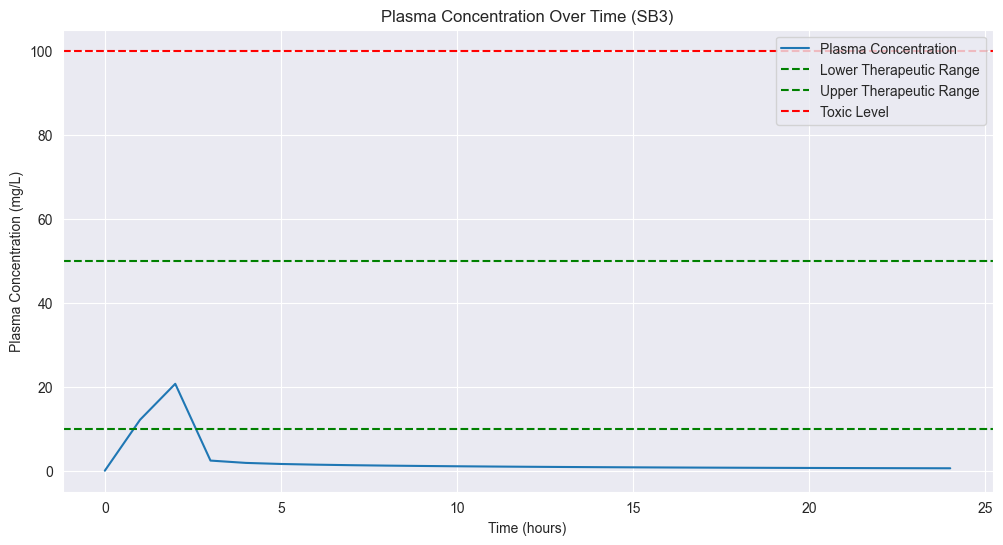

In [20]:
# Access the underlying environment from DummyVecEnv
underlying_env = env.envs[0]

# Plot plasma concentration from the last evaluation episode
plt.figure(figsize=(12, 6))
plt.plot(plasma_concentration_trajectories[-1], label="Plasma Concentration")
plt.axhline(y=underlying_env.therapeutic_range[0], color="g", linestyle="--", label="Lower Therapeutic Range")
plt.axhline(y=underlying_env.therapeutic_range[1], color="g", linestyle="--", label="Upper Therapeutic Range")
plt.axhline(y=100, color="r", linestyle="--", label="Toxic Level")
plt.xlabel("Time (hours)")
plt.ylabel("Plasma Concentration (mg/L)")
plt.title("Plasma Concentration Over Time (SB3)")
plt.legend()
plt.grid(True)
plt.show()


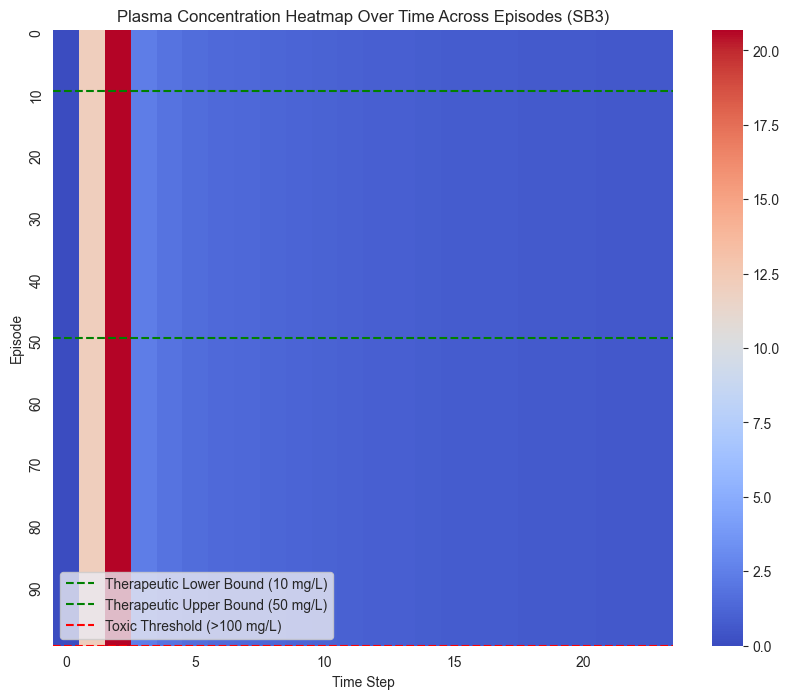

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables to store plasma concentration trajectories over episodes
plasma_concentrations_over_episodes = []

# Run the agent for several episodes to collect plasma concentration data
for episode in range(100):  # Number of training episodes
    state_trajectory = []  # Store the plasma concentration for this episode
    state = env.reset()  # Corrected to unpack only one value (state)
    done = False

    while not done:
        state_trajectory.append(state[0])  # Record plasma concentration
        action, _ = final_model.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)  # Correct unpacking for DummyVecEnv

    # Append the trajectory of plasma concentrations for this episode
    plasma_concentrations_over_episodes.append(state_trajectory)

# Convert the list of plasma concentrations into a 2D array (episodes x time steps)
# Flatten the 3D array (100, 24, 1) into a 2D array (100, 24)
plasma_concentrations_matrix = np.squeeze(np.array(plasma_concentrations_over_episodes))

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(plasma_concentrations_matrix, cmap='coolwarm', annot=False, cbar=True, xticklabels=5, yticklabels=10)
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Episode')
plt.title('Plasma Concentration Heatmap Over Time Across Episodes (SB3)')
plt.legend()
plt.grid()
plt.show()


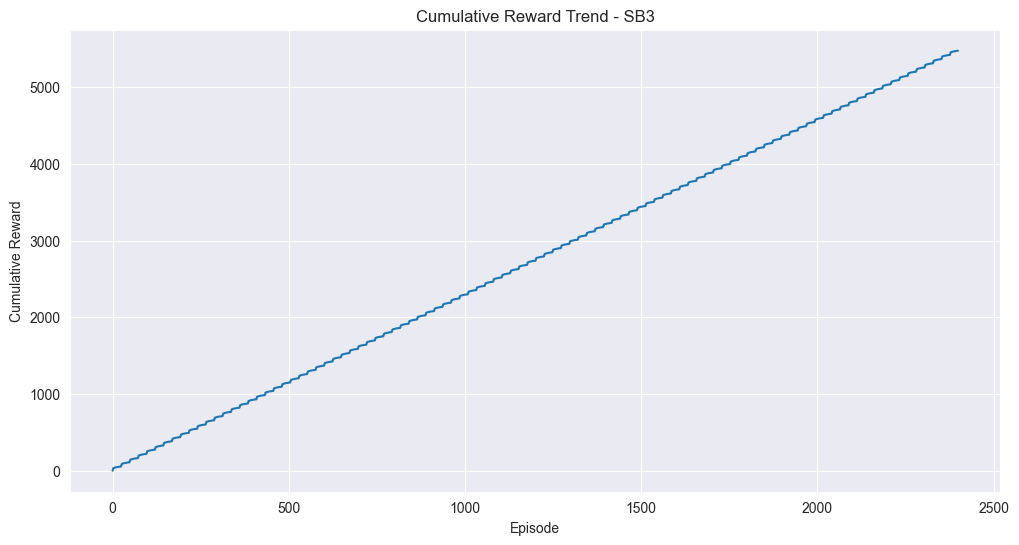

In [27]:

cumulative_rewards = np.cumsum(plasma_concentrations_over_episodes)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Trend - SB3")
plt.grid(True)
plt.show()

In [29]:
optuna.visualization.plot_optimization_history(study).show()


In [15]:
optuna.visualization.plot_param_importances(study).show()


/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_8431/456787015.py:19: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



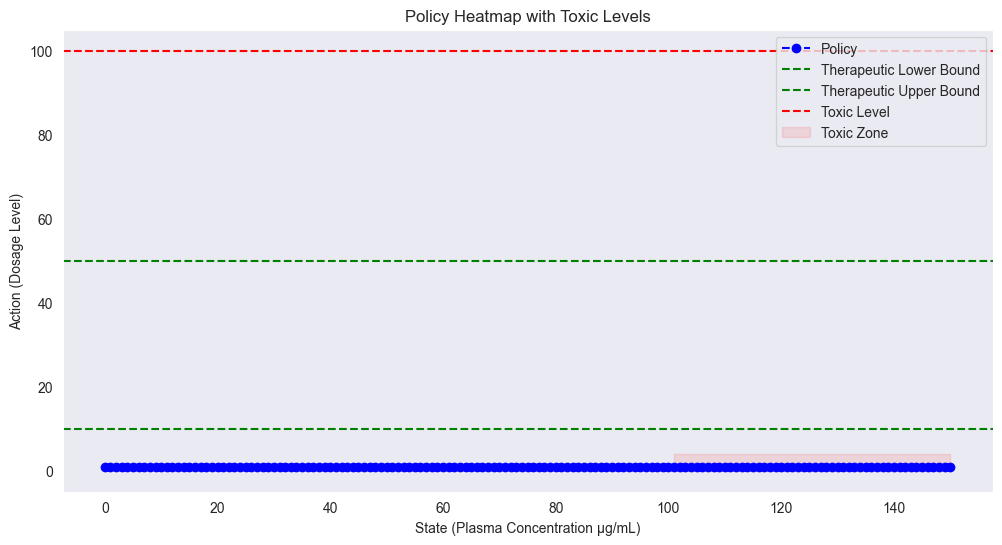

In [31]:
# Access the underlying environment
underlying_env = env.envs[0]  # Unwrap the DummyVecEnv

# Discretize the state space (e.g., plasma concentrations from 0 to 150 µg/mL)
state_space = np.linspace(0, 150, 151)

# Initialize an array to store the actions selected by the policy
policy_grid = np.zeros(len(state_space))

# Query the policy for each state
for i, state in enumerate(state_space):
    # Set the state as a numpy array (matching the environment's format)
    state_array = np.array([state], dtype=np.float32).reshape(1, -1)
    
    # Query the policy for the action
    action, _ = final_model.predict(state_array, deterministic=True)
    
    # Store the action in the policy grid
    policy_grid[i] = action

# Create a mask for toxic levels (above 100 µg/mL)
toxic_mask = state_space > 100

# Plot the policy heatmap with toxic levels
plt.figure(figsize=(12, 6))

# Plot the policy actions
plt.plot(state_space, policy_grid, marker="o", linestyle="--", color="blue", label="Policy")

# Highlight the therapeutic range
plt.axhline(y=underlying_env.therapeutic_range[0], color="green", linestyle="--", label="Therapeutic Lower Bound")
plt.axhline(y=underlying_env.therapeutic_range[1], color="green", linestyle="--", label="Therapeutic Upper Bound")

# Highlight the toxic level
plt.axhline(y=100, color="red", linestyle="--", label="Toxic Level")

# Shade the toxic region
plt.fill_between(state_space, 0, underlying_env.action_space.n - 1, where=toxic_mask, color="red", alpha=0.1, label="Toxic Zone")

# Add labels and legend
plt.xlabel("State (Plasma Concentration µg/mL)")
plt.ylabel("Action (Dosage Level)")
plt.title("Policy Heatmap with Toxic Levels")
plt.legend()
plt.grid()
plt.show()
